# TODO
* RT regression model
    * choice ~ prev_choice + prev_reward + prev_RT
* Run RL models on new, clean data
    * Exclude for 10 sessiosn and 500 trials
    * Make sure I'm doing everything I'm doing in the notebook
    * Could I just use true_dat?
* Plot results using old notebook
* Add RTs into model
    * Modulates alpha? -> dopamine = RPE
    * Modulates beta? -> dopamine = response vigor
* Is the RT model better than the no-RT model? -> Plot (W)AIC etc.
* Hierarchical fitting
    * Baseline model: $\theta \sim 1$ (just regular group-level priors)
    * Age group differences: $\theta \sim agegroup$ (two groups based on agegroup)
    * Meta-learning: $\theta \sim session$ (linear effect of session? quadratic?)
    * Age group and meta-learning: $\theta \sim session + agegroup$ (how do I specify within- vs between-participant factors? {session vs agegroup)
    * Differences in meta-learning based on agegroup: $\theta \sim session \times agegroup$
    * Model comparison using WAIC
* CHECK Split pre-processing into separate notebook
* CHECK Basic RT plots
    * CHECK RT over sessions, blocks, trials
    * CHECK RT differences reward vs no-reward; correct vs incorrect

# Imports etc.

In [1]:
import ipdb
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import scipy
import statsmodels.formula.api as smf

from Functions import get_info_from_fullID, add_meta_column, sigmoid, get_session

In [2]:
fitted_param_dir = 'C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice/'
mouse_data_dir = 'C:/Users/maria/MEGAsync/SLCN/PSMouseData'
plot_dir = 'C:/Users/maria/MEGAsync/SLCN/models/plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [3]:
# save_or_load_true_mouse_dat = 'load'  # 'save', 'load'
# save_or_load_sim_mouse_dat = 'save'  # 'save', 'load'
n_trial_cutoff = 500  # 500 as of 2020/07/21
n_session_cutoff = 10  # 10 as of 2020/07/21
# rt_cut_off = 10  # 10 seconds as of 2020/07/29

# Get cleaned mouse data

In [4]:
true_dat_all = pd.read_csv(os.path.join(mouse_data_dir, 'mouse_true_dat_raw.csv'))
true_dat_all

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (75) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,act_18ago,act_19ago,block_length,block_trial,trials2switch,session,rew_1&2ago,cor_1&2ago,act_1&2ago,meta
0,0.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,12.0,0.0,0.0,0.0,nn,nn,nn,1-3
1,0.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,12.0,1.0,1.0,0.0,0n,0n,0n,1-3
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,12.0,2.0,2.0,0.0,00,00,00,1-3
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,12.0,3.0,3.0,0.0,10,10,10,1-3
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,12.0,4.0,4.0,0.0,11,11,11,1-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354241,NaN,NaN,NaN,NaN,777,NaN,1309021,Adult,Female,90,...,1.0,1.0,NaN,NaN,NaN,15.0,nn,nn,nn,NaN
354242,NaN,NaN,NaN,NaN,778,NaN,1309021,Adult,Female,90,...,1.0,1.0,NaN,NaN,NaN,15.0,nn,nn,nn,NaN
354243,NaN,NaN,NaN,NaN,779,NaN,1309021,Adult,Female,90,...,1.0,1.0,NaN,NaN,NaN,15.0,nn,nn,nn,NaN
354244,NaN,NaN,NaN,NaN,780,NaN,1309021,Adult,Female,90,...,1.0,1.0,NaN,NaN,NaN,15.0,nn,nn,nn,NaN


In [5]:
true_dat = pd.read_csv(os.path.join(mouse_data_dir, 'true_dat.csv'))
true_dat

,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,act_19ago,block_length,block_trial,trials2switch,session,rew_1&2ago,cor_1&2ago,act_1&2ago,meta,excluded
0,0.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,NaN,12.0,0.0,0.0,0.0,nn,nn,nn,1-3,False
1,0.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,NaN,12.0,1.0,1.0,0.0,0n,0n,0n,1-3,False
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,NaN,12.0,2.0,2.0,0.0,00,00,00,1-3,False
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,NaN,12.0,3.0,3.0,0.0,10,10,10,1-3,False
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,NaN,12.0,4.0,4.0,0.0,11,11,11,1-3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193995,1.0,0.0,0.59100,0.0,495,21.0,1308321,Adult,Female,83,...,0.0,32.0,21.0,21.0,10.0,01,11,00,9-11,False
193996,1.0,0.0,2.18350,0.0,496,21.0,1308321,Adult,Female,83,...,0.0,32.0,22.0,22.0,10.0,00,01,10,9-11,False
193997,0.0,0.0,0.36100,1.0,497,21.0,1308321,Adult,Female,83,...,0.0,32.0,23.0,23.0,10.0,00,00,11,9-11,False
193998,0.0,1.0,NaN,1.0,498,21.0,1308321,Adult,Female,83,...,0.0,32.0,24.0,24.0,10.0,00,10,01,9-11,False


In [6]:
# Make agegroup and sex ordered categorical columns
true_dat['agegroup'] = pd.Categorical(true_dat.agegroup, categories=('Juvenile', 'Adult'), ordered=True)
true_dat['sex'] = pd.Categorical(true_dat.sex, categories=('Male', 'Female'), ordered=True)
true_dat_all['agegroup'] = pd.Categorical(true_dat_all.agegroup, categories=('Juvenile', 'Adult'), ordered=True)
true_dat_all['sex'] = pd.Categorical(true_dat_all.sex, categories=('Male', 'Female'), ordered=True)

# Run regression models

## Agegroup differences in performance?

In [7]:
# Summarize data for regression
mean_dat = true_dat.groupby(['fullID']).mean().reset_index()
mean_dat['sex'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x, 'sex'))
mean_dat['agegroup'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x, 'agegroup'))
mean_dat['meta'] = add_meta_column(mean_dat)
mean_dat

,fullID,action,reward,rt,correct,trial,block,age,animal,rew_1ago,...,act_18ago,act_19ago,block_length,block_trial,trials2switch,session,excluded,sex,agegroup,meta
0,107511,0.480,0.604,0.657764,0.780,249.5,10.184,75.0,1.0,0.605210,...,0.483402,0.484407,25.888,12.252,9.348,0.0,False,Male,Adult,1-3
1,107611,0.488,0.594,0.692603,0.792,249.5,9.736,76.0,1.0,0.593186,...,0.506224,0.507277,30.758,14.798,11.960,1.0,False,Male,Adult,1-3
2,107711,0.496,0.548,0.759884,0.742,249.5,7.710,77.0,1.0,0.549098,...,0.479253,0.480249,31.596,14.994,12.108,2.0,False,Male,Adult,1-3
3,107811,0.456,0.608,0.726541,0.790,249.5,7.974,78.0,1.0,0.609218,...,0.437759,0.438669,30.686,14.786,11.900,3.0,False,Male,Adult,4-8
4,107911,0.486,0.612,0.681527,0.800,249.5,9.046,79.0,1.0,0.613226,...,0.481328,0.480249,28.736,13.742,10.796,4.0,False,Male,Adult,4-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,3805212,0.480,0.602,0.999989,0.774,249.5,8.846,52.0,38.0,0.601202,...,0.489627,0.488565,29.936,14.352,11.376,4.0,False,Male,Juvenile,4-8
384,3805412,0.522,0.598,0.935295,0.788,249.5,10.958,54.0,38.0,0.597194,...,0.512448,0.511435,26.616,12.808,9.808,5.0,False,Male,Juvenile,4-8
385,3805612,0.576,0.542,1.654544,0.720,249.5,10.124,56.0,38.0,0.543086,...,0.580913,0.582121,27.544,13.162,10.192,6.0,False,Male,Juvenile,4-8
386,3805812,0.522,0.586,0.788020,0.798,249.5,9.276,58.0,38.0,0.585170,...,0.512448,0.513514,26.412,12.706,9.706,7.0,False,Male,Juvenile,4-8


In [8]:
# Simple model based on mean data (1 data point per mouse per session)
print(smf.ols(
    "correct ~ (session + sex + agegroup) * (session + sex + agegroup)",
    mean_dat,
).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                correct   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     20.61
Date:                Mon, 03 Aug 2020   Prob (F-statistic):           6.38e-21
Time:                        11:55:51   Log-Likelihood:                 835.48
No. Observations:                 388   AIC:                            -1657.
Df Residuals:                     381   BIC:                            -1629.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [9]:
# Mixed-effects model based on all data (500 trials per animal per session)
# PROBLEM: I WANT TO RUN A LOGIT MODEL, NOT LINEAR REGRESSION; CORRECT IS BINARY
print(smf.mixedlm(
    "correct ~ (block + session + sex + agegroup) * (block + session + sex + agegroup)",
    true_dat,
    groups=true_dat["animal"]  # Default random effects structure: random intercept for each group
).fit().summary())

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      correct     
No. Observations:        194000       Method:                  REML        
No. Groups:              38           Scale:                   0.1703      
Min. group size:         2500         Likelihood:              -103662.3732
Max. group size:         5500         Converged:               Yes         
Mean group size:         5105.3                                            
---------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.765    0.005 141.773 0.000  0.755  0.776
sex[T.Female]                   -0.013    0.008  -1.741 0.082 -0.029  0.002
agegroup[T.Adult]               -0.027    0.008  -3.217 0.001 -0.043 -0.010
sex[T.Female]:agegroup[T.Adult]

In [10]:
# from statsmodels.formula.api import logit
# PROBLEM: I WANT TO RUN A MIXED-EFFECTS MODEL, NOT FLAT; TRIALS ARE NESTED WITHIN ANIMALS
print(smf.logit(
    "correct ~ (block + session + sex + agegroup) * (block + session + sex + agegroup)",
    true_dat,
).fit().summary())

Optimization terminated successfully.
         Current function value: 0.524133
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                correct   No. Observations:               194000
Model:                          Logit   Df Residuals:                   193989
Method:                           MLE   Df Model:                           10
Date:                Mon, 03 Aug 2020   Pseudo R-squ.:                0.001719
Time:                        11:55:55   Log-Likelihood:            -1.0168e+05
converged:                       True   LL-Null:                   -1.0186e+05
Covariance Type:            nonrobust   LLR p-value:                 3.518e-69
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.1765      0.023     50.546  

In [11]:
# Post-hoc t-tests
print("\nTesting differences between juveniles and adults:")
for sex in np.unique(mean_dat.sex):
    for meta in np.unique(mean_dat.meta):
        
        sub_dat = mean_dat[(mean_dat.meta == meta) * (mean_dat.sex == sex)]
        t, p = scipy.stats.ttest_ind(
            sub_dat.correct[sub_dat.agegroup == 'Juvenile'],
            sub_dat.correct[sub_dat.agegroup == 'Adult']
        )
        print("\t{}s, sessions {}: t={}, p={}".format(sex, meta, round(t, 1), round(p, 4)))


Testing differences between juveniles and adults:
	Females, sessions 1-3: t=1.5, p=0.138
	Females, sessions 4-8: t=-0.2, p=0.8082
	Females, sessions 9-11: t=-1.9, p=0.0678
	Males, sessions 1-3: t=0.7, p=0.5124
	Males, sessions 4-8: t=0.9, p=0.3584
	Males, sessions 9-11: t=-0.0, p=0.9939


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


## Complex model, predicting future chioces from past choice, rewards, and RTs

In [12]:
# Add predictors
for n in range(1, 20):
    
    true_dat['reward_{}ago'.format(n)] = true_dat['rew_{}ago'.format(n)].copy()  # reward => reward = 1; no reward => reward = 0
    true_dat['norew_{}ago'.format(n)] = 1 - true_dat['reward_{}ago'.format(n)]  # reward => norew = 0; no reward => norew = 1
#     true_dat['stay_{}ago'.format(n)] = (true_dat['action'] == true_dat['act_{}ago'.format(n)]).astype(int)  # action now == action then => stay = 1
#     true_dat['switch_{}ago'.format(n)] = (true_dat['action'] != true_dat['act_{}ago'.format(n)]).astype(int)  # switch
    true_dat.loc[true_dat['act_{}ago'.format(n)] == 0, 'reward_{}ago'.format(n)] *= -1  # reward & action==right => 1; reward & action==left => -1
    true_dat.loc[true_dat['act_{}ago'.format(n)] == 0, 'norew_{}ago'.format(n)] *= -1  # no reward & action==right => 1; no reward & action==left => -1
#     true_dat.loc[true_dat['act_{}ago'.format(n)] == 0, 'stay_{}ago'.format(n)] *= -1  # stay & action==right => 1; stay & action left => -1
#     true_dat.loc[true_dat['act_{}ago'.format(n)] == 0, 'switch_{}ago'.format(n)] *= -1  # stay & action==right => 1; stay & action left => -1

true_dat.action = 2 * true_dat.action - 1  # left action => -1; right action => +1
true_dat

,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,reward_15ago,norew_15ago,reward_16ago,norew_16ago,reward_17ago,norew_17ago,reward_18ago,norew_18ago,reward_19ago,norew_19ago
0,-1.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193995,1.0,0.0,0.59100,0.0,495,21.0,1308321,Adult,Female,83,...,-0.0,-1.0,-1.0,-0.0,-0.0,-1.0,-1.0,-0.0,-1.0,-0.0
193996,1.0,0.0,2.18350,0.0,496,21.0,1308321,Adult,Female,83,...,0.0,1.0,-0.0,-1.0,-1.0,-0.0,-0.0,-1.0,-1.0,-0.0
193997,-1.0,0.0,0.36100,1.0,497,21.0,1308321,Adult,Female,83,...,-0.0,-1.0,0.0,1.0,-0.0,-1.0,-1.0,-0.0,-0.0,-1.0
193998,-1.0,1.0,NaN,1.0,498,21.0,1308321,Adult,Female,83,...,-1.0,-0.0,-0.0,-1.0,0.0,1.0,-0.0,-1.0,-1.0,-0.0


In [13]:
def mod_fit_to_dataframe(results):
    
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame(
        {"p": pvals,
         "coef": coeff,
         "ci_low": conf_lower,
         "ci_high": conf_higher
        }
    )

    return results_df

# # Example use
# mod_fit_to_dataframe(mod)

In [14]:
all_model_results_raw = pd.DataFrame()

fullIDs = np.unique(true_dat.fullID)
for i, fullID in enumerate(fullIDs[:10]):
    
    sub_dat = true_dat.loc[(true_dat.fullID == fullID) & (true_dat.rt < 0.5)]
    
    for n in range(1, 20):
        try:
#             mod = smf.logit(
#                 'action ~ rew_{}ago_ * act_{}ago_'.format(n, n),
#                 sub_dat,
#             ).fit()

#             mod = smf.logit(
#                 'action ~ reward_{}ago + norew_{}ago'.format(n, n, n),
#                 sub_dat,
#             ).fit()

            mod = smf.ols(
                'action ~ reward_{}ago + norew_{}ago'.format(n, n, n),
                sub_dat,
            ).fit()

            model_results = mod_fit_to_dataframe(mod)
            model_results['fullID'] = fullID
            model_results['n_ago'] = -n

            all_model_results_raw = pd.concat([all_model_results_raw, model_results], axis=0)

        except:
            print("\nModel didn't converge for {}.\n".format(fullID))
    
all_model_results_raw

,p,coef,ci_low,ci_high,fullID,n_ago
Intercept,4.002651e-01,0.032707,-0.043747,0.109162,107511,-1
reward_1ago,3.011307e-54,0.997601,0.900354,1.094848,107511,-1
norew_1ago,3.801463e-11,0.414838,0.296811,0.532865,107511,-1
Intercept,4.986141e-01,-0.029238,-0.114216,0.055741,107511,-2
reward_2ago,1.328633e-44,0.888822,0.787955,0.989689,107511,-2
...,...,...,...,...,...,...
reward_18ago,2.352018e-09,-0.412941,-0.545134,-0.280748,108411,-18
norew_18ago,9.519065e-04,-0.270406,-0.429912,-0.110900,108411,-18
Intercept,1.695177e-01,0.071238,-0.030554,0.173029,108411,-19
reward_19ago,5.908783e-10,-0.426380,-0.557702,-0.295058,108411,-19


In [15]:
# Add measures as column
all_model_results = all_model_results_raw.reset_index(
    ).rename(columns={'index': 'predictor'})

# Add general predictor columns
all_model_results['pred'] = all_model_results.predictor.apply(lambda x : x[:5])

# Add sigmoid columns
all_model_results = all_model_results.loc[(all_model_results.coef > -1000) & (all_model_results.coef < 1000)]  # exclude crazy values
all_model_results['sig_coef'] = sigmoid(all_model_results.coef)

# Add animal columns
all_model_results['sex'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'sex'))
all_model_results['agegroup'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'agegroup'))
all_model_results['age'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'age'))
all_model_results['animal'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'animal'))

for ani in np.unique(all_model_results.animal):
    all_model_results.loc[all_model_results.animal == ani, 'session'] = get_session(
        all_model_results.loc[all_model_results.animal == ani])  # needs to be within loops over animals
all_model_results['meta'] = add_meta_column(all_model_results)  # needs session column

# Check it out
all_model_results[:30]

,predictor,p,coef,ci_low,ci_high,fullID,n_ago,pred,sig_coef,sex,agegroup,age,animal,session,meta
0,Intercept,4.002651e-01,0.032707,-0.043747,0.109162,107511,-1,Inter,0.508176,Male,Adult,75,1,0,1-3
1,reward_1ago,3.011307e-54,0.997601,0.900354,1.094848,107511,-1,rewar,0.730587,Male,Adult,75,1,0,1-3
2,norew_1ago,3.801463e-11,0.414838,0.296811,0.532865,107511,-1,norew,0.602247,Male,Adult,75,1,0,1-3
3,Intercept,4.986141e-01,-0.029238,-0.114216,0.055741,107511,-2,Inter,0.492691,Male,Adult,75,1,0,1-3
4,reward_2ago,1.328633e-44,0.888822,0.787955,0.989689,107511,-2,rewar,0.708647,Male,Adult,75,1,0,1-3
5,norew_2ago,3.063020e-02,0.166706,0.015696,0.317716,107511,-2,norew,0.541580,Male,Adult,75,1,0,1-3
6,Intercept,6.765237e-01,-0.020129,-0.115045,0.074787,107511,-3,Inter,0.494968,Male,Adult,75,1,0,1-3
7,reward_3ago,9.422864e-34,0.864085,0.744040,0.984130,107511,-3,rewar,0.703513,Male,Adult,75,1,0,1-3
8,norew_3ago,8.001934e-01,0.019135,-0.129618,0.167889,107511,-3,norew,0.504784,Male,Adult,75,1,0,1-3
9,Intercept,6.598677e-02,-0.084155,-0.173910,0.005601,107511,-4,Inter,0.478974,Male,Adult,75,1,0,1-3


In [16]:
# Save as csv
all_model_results.to_csv(os.path.join(mouse_data_dir, 'all_model_results.csv'))

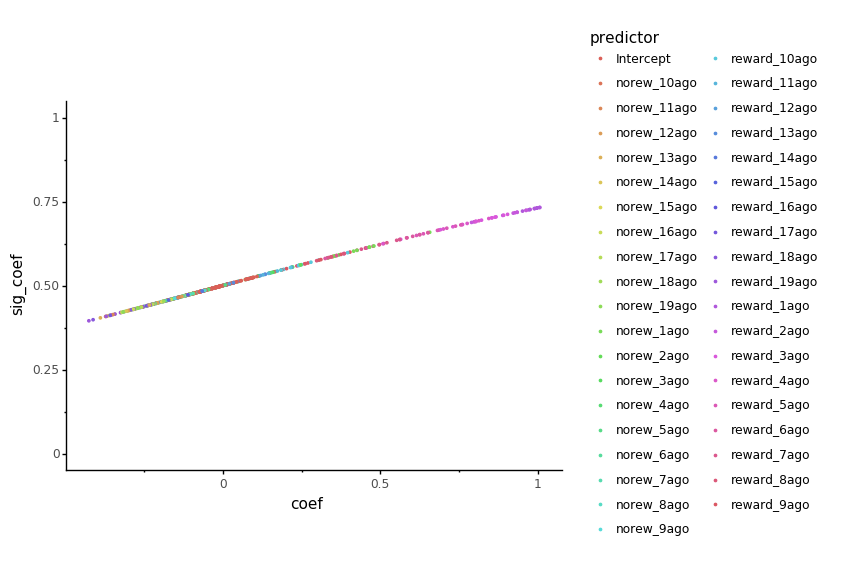

<ggplot: (-9223371856931439356)>

In [17]:
# Check out sigmoided coefficients
g = (gg.ggplot(all_model_results, gg.aes('coef', 'sig_coef', color='predictor'))
     + gg.geom_point(size=0.5)
     + gg.coord_cartesian(ylim=(0, 1))
    )
g

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 5 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\5_regression_sig_coefs.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


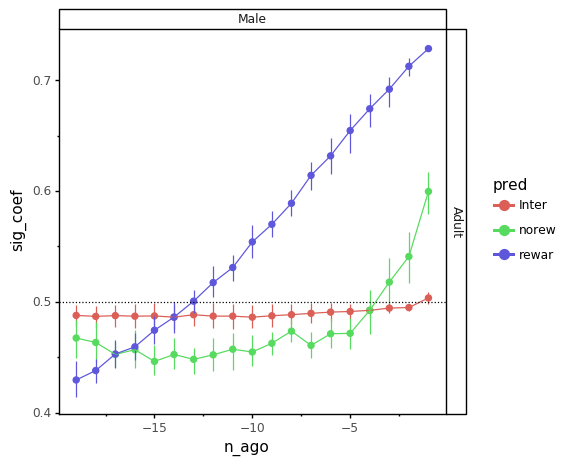

<ggplot: (179851958988)>

In [18]:
# Plot coefficients
gg.options.figure_size = (5, 5)
g = (gg.ggplot(all_model_results, gg.aes('n_ago', 'sig_coef', color='pred'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.geom_hline(yintercept=0.5, linetype='dotted')
     + gg.facet_grid('agegroup ~ sex')
    )
g.save(os.path.join(plot_dir, '5_regression_sig_coefs.png'))
g

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 5 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\5_regression_coefs.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


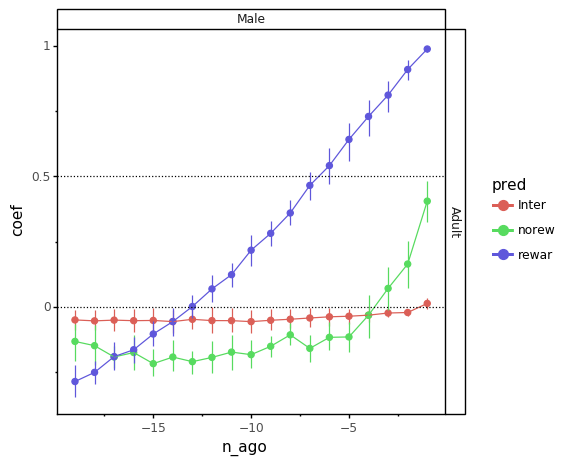

<ggplot: (-9223371857002589296)>

In [19]:
g2 = g + gg.aes(y='coef') + gg.geom_hline(yintercept=0, linetype='dotted')
g2.save(os.path.join(plot_dir, '5_regression_coefs.png'))
g2

### Understanding why

In [20]:
# Making sure everything is coded right:
    # no reward + left (0.0)  => norew -1, reward 0
    # no reward + right (1.0) => norew +1, reward 0
    #    reward + left (0.0)  => reward -1, norew 0
    #    reward + right (1.0) => reward +1, norew 0
true_dat.loc[:30, ['fullID', 'trial', 'reward', 'action', 'reward_1ago', 'norew_1ago', 'stay_1ago', 'stay_2ago', 'switch_1ago']]

,fullID,trial,reward,action,reward_1ago,norew_1ago,stay_1ago,stay_2ago,switch_1ago
0,1404012,0,0.0,-1.0,NaN,NaN,NaN,NaN,NaN
1,1404012,1,0.0,-1.0,-0.0,-1.0,NaN,NaN,NaN
2,1404012,2,1.0,1.0,-0.0,-1.0,NaN,NaN,NaN
3,1404012,3,1.0,1.0,1.0,0.0,NaN,NaN,NaN
4,1404012,4,1.0,1.0,1.0,0.0,NaN,NaN,NaN
5,1404012,5,1.0,1.0,1.0,0.0,NaN,NaN,NaN
6,1404012,6,1.0,1.0,1.0,0.0,NaN,NaN,NaN
7,1404012,7,1.0,1.0,1.0,0.0,NaN,NaN,NaN
8,1404012,8,1.0,1.0,1.0,0.0,NaN,NaN,NaN
9,1404012,9,1.0,1.0,1.0,0.0,NaN,NaN,NaN


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 203 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


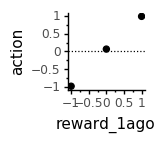

<ggplot: (179852280391)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 203 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


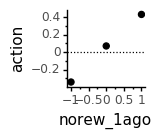

<ggplot: (179851933781)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 389 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


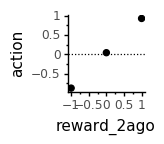

<ggplot: (-9223371857002906175)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 389 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


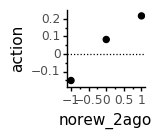

<ggplot: (179858370617)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 556 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


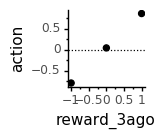

<ggplot: (-9223371857002346282)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 556 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


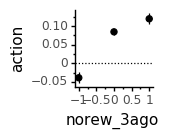

<ggplot: (-9223371856996494648)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 734 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


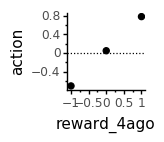

<ggplot: (-9223371856996490829)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 734 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


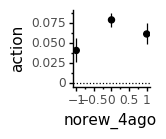

<ggplot: (179858208127)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 938 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


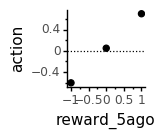

<ggplot: (179851879537)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 938 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


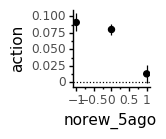

<ggplot: (-9223371856996523425)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1151 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


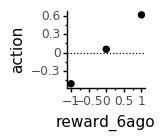

<ggplot: (-9223371857002487008)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1151 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


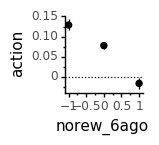

<ggplot: (179852426844)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1379 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


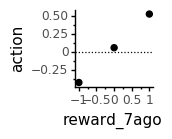

<ggplot: (179858205511)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1379 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


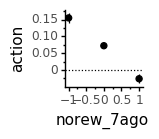

<ggplot: (-9223371857002989308)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1616 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


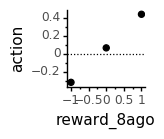

<ggplot: (179925270827)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1616 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


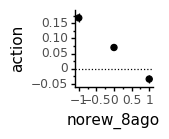

<ggplot: (-9223371856996425419)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1846 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


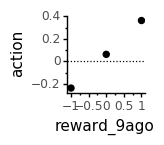

<ggplot: (-9223371856996400580)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1846 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


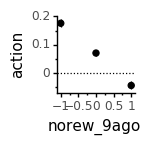

<ggplot: (-9223371857002483035)>


In [23]:
gg.options.figure_size = (1, 1)
sub_dat = true_dat.loc[true_dat.rt < 0.5]

for ago in range(1, 10):
    
    # Reward effect looks good: Mice choose left after left-reward, and right after right-reward
    gr = (gg.ggplot(sub_dat, gg.aes('reward_{}ago'.format(ago), 'action'))
         + gg.stat_summary()
         + gg.theme(legend_position='none')
         + gg.geom_hline(yintercept=0, linetype='dotted')
#          + gg.geom_hline(yintercept=1, linetype='dotted')
    )
    print(gr)

    # No reward effect looks wrong: Mice choose left after left-NO reward, and right after right-NO reward
    gn = gr + gg.aes('norew_{}ago'.format(ago))
    print(gn)

#     # Stay looks a little skewed too: Mice repeat right more than left
#     gs = gr + gg.aes('stay_{}ago'.format(ago))
#     print(gs)

gg.options.figure_size = (5, 5)

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 388 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


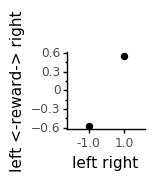

<ggplot: (-9223371856996483994)>


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 388 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


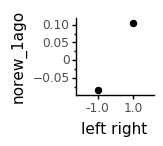

<ggplot: (179858183649)>


PlotnineError: "Could not evaluate the 'y' mapping: 'stay_1ago' (original error: name 'stay_1ago' is not defined)"

In [22]:
gg.options.figure_size = (1, 1)

# Reward effect looks good: Mice choose left after left-reward, and right after right-reward
gr = (gg.ggplot(true_dat, gg.aes('factor(action)', 'reward_1ago'))
     + gg.stat_summary()
     + gg.theme(legend_position='none')
     + gg.labs(x='left right', y='left <-reward-> right')
)
print(gr)

# No reward effect looks wrong: Mice choose left after left-NO reward, and right after right-NO reward
gn = gr + gg.aes(y='norew_1ago')
print(gn)

# Stay looks a little skewed too: Mice repeat right more than left
gs = gr + gg.aes(y='stay_1ago')
print(gs)

gg.options.figure_size = (5, 5)

# OLD

In [ ]:
true_dat['session2'] = 2 * np.round(true_dat.session / 2)
true_dat['session3'] = 3 * np.round(true_dat.session / 3)
sub = true_dat[(true_dat.agegroup == "Juvenile")]
g = (gg.ggplot(sub, gg.aes('age', 'correct', color='factor(session)', group='factor(session)'))
     + gg.stat_summary()
     + gg.stat_summary(geom="line")
     + gg.facet_grid('~ gender')
    )
g

In [ ]:
# Summarize data for regression
low, high = 1, 5
mean_dat = true_dat[
        (true_dat.trials2switch >= low) * (true_dat.trials2switch <= high) * (true_dat.meta == '1-3')
    ].groupby(['fullID']).mean().reset_index()
mean_dat['gender'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['gender'][0])
mean_dat['agegroup'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['agegroup'][0])

mean_dat['meta'] = np.nan
mean_dat.loc[mean_dat.session <= 2, 'meta'] = '1-3'
mean_dat.loc[(mean_dat.session >= 3) * (mean_dat.session <= 7), 'meta'] = '4-8'
mean_dat.loc[(mean_dat.session >= 8) * (mean_dat.session <= 10), 'meta'] = '9-11'
mean_dat = mean_dat.dropna(subset=['meta'])
mean_dat['meta'] = pd.Categorical(mean_dat['meta'], ordered=True, categories=('1-3', '4-8', '9-11'))
# mean_dat['meta'] = add_meta_column(mean_dat)
mean_dat

In [ ]:
# Agegroup differences in performace?
print(smf.ols(
    "correct ~ (trials2switch + session + gender + agegroup) * (trials2switch + session + gender + agegroup)",
    mean_dat,
).fit().summary())

In [ ]:
# Summarize data for regression
low, high = 1, 5
mean_dat = true_dat[
        (true_dat.trials2switch >= low) * (true_dat.trials2switch <= high)
    ].groupby(['fullID']).mean().reset_index()
mean_dat['gender'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['gender'][0])
mean_dat['agegroup'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['agegroup'][0])

mean_dat['meta'] = np.nan
mean_dat.loc[mean_dat.session <= 2, 'meta'] = '1-3'
mean_dat.loc[(mean_dat.session >= 3) * (mean_dat.session <= 7), 'meta'] = '4-8'
mean_dat.loc[(mean_dat.session >= 8) * (mean_dat.session <= 10), 'meta'] = '9-11'
mean_dat = mean_dat.dropna(subset=['meta'])
mean_dat['meta'] = pd.Categorical(mean_dat['meta'], ordered=True, categories=('1-3', '4-8', '9-11'))
# mean_dat['meta'] = add_meta_column(mean_dat)
mean_dat

In [ ]:
# Agegroup differences in performace?
print(smf.ols(
    "correct ~ (trials2switch + session + gender + agegroup) * (trials2switch + session + gender + agegroup)",
#     "correct ~ gender + trials2switch + session + agegroup + session:agegroup + trials2switch:session:agegroup + trials2switch:session",
    mean_dat,
).fit().summary())

In [ ]:
# Age group difference in early sessions?
low, hig = 1, 6
sub_dat_t = true_dat[(true_dat.meta == '0-2') * (true_dat.trials2switch >= low) * (true_dat.trials2switch < hig)]
print(smf.mixedlm(
    "correct ~ (trials2switch + gender + session + agegroup) * (trials2switch + gender + session + agegroup)",
    sub_dat_t,
    groups=sub_dat_t["animal"]  # Default random effects structure: random intercept for each group
).fit().summary())

# Do adults do more meta-learning than juveniles?
sub_dat_t = true_dat[(true_dat.trials2switch >= low) * (true_dat.trials2switch < hig)]
print(smf.mixedlm(
    "correct ~ (trials2switch + gender + session) * (trials2switch + gender + session) * agegroup",
    sub_dat_t,
    groups=sub_dat_t["animal"]  # Default random effects structure: random intercept for each group
).fit().summary())

In [ ]:
import numpy as np                                                                                         
import statsmodels.api as sm                                                                               
import pandas as pd                                                                                        
                                                                                                           
# create fake data                                                                                         
# y: binary response                                                                                       
# x: continuous predictor                                                                                  
# re: three class random intercepts                                                                        
fakedata = pd.DataFrame({'y' : np.random.sample(50).round(),                                               
                         'x' : np.random.sample(50),                                                       
                         're' : (np.random.sample(50)*2).round().astype(int).astype(str)})
                                                          
# this is implemented as I understand the doc:                                                             
binom_model = sm.BinomialBayesMixedGLM(                                                                    
                                       fakedata['y'], # endog                                              
                                       fakedata['x'][:, None], # exog                                      
                                       pd.get_dummies(fakedata['re']), # Array of covariates for the random
                                       np.r_[0, 0, 0]) # ident, columns of exog_vc                         
binom_result = binom_model.fit_vb()
print(binom_result.summary())

In [ ]:
fakedata

In [ ]:
import numpy as np                                                                                                              
import pandas as pd                                                                                                             
from statsmodels.genmod.bayes_mixed_glm import PoissonBayesMixedGLM, BinomialBayesMixedGLM                                      
                                                                                                                                
n = 1000                                                                                                                        
m = 50 # Number of groups                                                                                                       
grp = np.random.randint(0, m, n)                                                                                                
grp_efx = np.random.normal(size=m)                                                                                              
n_relapse_xmt = np.random.normal(size=n)                                                                                        
lpr = grp_efx[grp] + n_relapse_xmt                                                                                              
mn = np.exp(lpr)                                                                                                                
total_days_AU_MS = np.random.poisson(mn)                                                                                        
X = pd.DataFrame({"total_days_AU_MS": total_days_AU_MS,                                                                         
                  "f_id_site": grp,                                                                                             
                  "n_relapse_xmt": n_relapse_xmt})                                                                              
                                                                                                                                
formula = 'total_days_AU_MS ~ 1 + n_relapse_xmt'                                                                                
                                                                                                                                
glm_model = PoissonBayesMixedGLM.from_formula(formula=formula,                                                                  
                vc_formulas={'f_id_site': '0 + C(f_id_site)'}, data=X)                                                          
glm_results = glm_model.fit_map()                                                                                               
print(glm_results.summary())  

In [ ]:
print(smf.mixedlm(
    "correct ~ (agegroup + session + gender) * (agegroup + session + gender)",
    sub_dat,
    groups=sub_dat.animal
).fit().summary())

In [ ]:
# PC_sim_dir = "C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat"

In [ ]:
# # Define simulations to be analzed
# n_agents = 100
# PC_sim_name = [f for f in os.listdir(PC_sim_dir) if ('.csv' in f) and ('params' in f)]
# model_names = [modelname.split('_')[1] for modelname in modelnames]
# print(model_names)

In [ ]:

# simulation_dir = os.path.join(PC_sim_dir, 'PC_{}_*.csv'.format(model_name, n_agents))
# if save_or_load_sim_mouse_dat == 'save':
#     sim_dat = pd.read_csv(simulation_dir)
#     sim_dat = format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True)
# else:
#     sim_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_sim_mouse_data_{}.csv'.format(model_name)))
# sim_dat = add_meta_column(sim_dat)
# sim_dat['agegroup'] = pd.Categorical(sim_dat['agegroup'], ordered=True, categories=('Juvenile', 'Adult'))

# # Plot simulated data
# print("Plotting...")
# make_trials2switch_plot(sim_dat, suf='sim' + model_name)
# make_12ago_plot(sim_dat, 'sim' + model_name)
# make_blocktrial_correct_plot(sim_dat, 'sim' + model_name)
# make_block_correct_plot(sim_dat, 'sim' + model_name)
# make_session_correct_plot(sim_dat, 'sim' + model_name)
# make_age_reward_plot(sim_dat, 'sim' + model_name)

In [ ]:

# # model_names = [ 'Bbspr', 'Bbp', 'Bbpr', 'Bb', 'B', 'RLabcd', 'RLabcpd', 'RLabcpnd', 'RLabcpnxd', 'RLabd', 'RLabnp2d', 'RLab']

# # Read in and format simulated data
# # for PC_sim_name in PC_sim_names:
#     print("Model {}".format(model_name))
#     simulation_dir = os.path.join(PC_sim_dir, 'simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents))
#     if save_or_load_sim_mouse_dat == 'save':
#         sim_dat = pd.read_csv(simulation_dir)
#         sim_dat = format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True)
#     else:
#         sim_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_sim_mouse_data_{}.csv'.format(model_name)))
#     sim_dat = add_meta_column(sim_dat)
#     sim_dat['agegroup'] = pd.Categorical(sim_dat['agegroup'], ordered=True, categories=('Juvenile', 'Adult'))
    
#     # Plot simulated data
#     print("Plotting...")
#     make_trials2switch_plot(sim_dat, suf='sim' + model_name)
#     make_12ago_plot(sim_dat, 'sim' + model_name)
#     make_blocktrial_correct_plot(sim_dat, 'sim' + model_name)
#     make_block_correct_plot(sim_dat, 'sim' + model_name)
#     make_session_correct_plot(sim_dat, 'sim' + model_name)
#     make_age_reward_plot(sim_dat, 'sim' + model_name)